# Khi làm việc trên colab hay kaggle, phải cài caer và canaro

In [1]:
import os
import caer
import canaro
import cv2 as cv
import gc

In [2]:
# Cần các image trong dataset có cùng kích thước
IMG_SIZE = (80, 80)
# Cơ bản chỉ cần ảnh gray là đủ nên chỉ cần 1 channel
channels = 1
char_path = 'dataset/simpsons_dataset'

In [3]:
# Lấy 10 chracter có nhiều ảnh nhất
# Đi vào trong tất cả folder, lấy số lượng image và gán nó vào dictionary, xếp nó theo thứ tự giảm dần và lấy 10 phần tử đầu tiên
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [4]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count +=1
    if count >=10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

# Create the training data

In [5]:
# Đi đến tất cả folder trong char_path và lookup tất cả những folder trong chracter
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.01858043670654297s
[INFO] At 1000 files
[INFO] 1454 files found in 0.0070285797119140625s
[INFO] At 1000 files
[INFO] 1452 files found in 0.009253978729248047s
[INFO] At 1000 files
[INFO] 1354 files found in 0.006378173828125s
[INFO] At 1000 files
[INFO] 1342 files found in 0.0042285919189453125s
[INFO] At 1000 files
[INFO] 1291 files found in 0.0064394474029541016s
[INFO] At 1000 files
[INFO] 1206 files found in 0.00629115104675293s
[INFO] At 1000 files
[INFO] 1194 files found in 0.005608320236206055s
[INFO] At 1000 files
[INFO] 1193 files found in 0.012455940246582031s
[INFO] At 1000 files
[INFO] 1079 files found in 0.007998228073120117s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 3m 12s


In [6]:
len(train)

13811

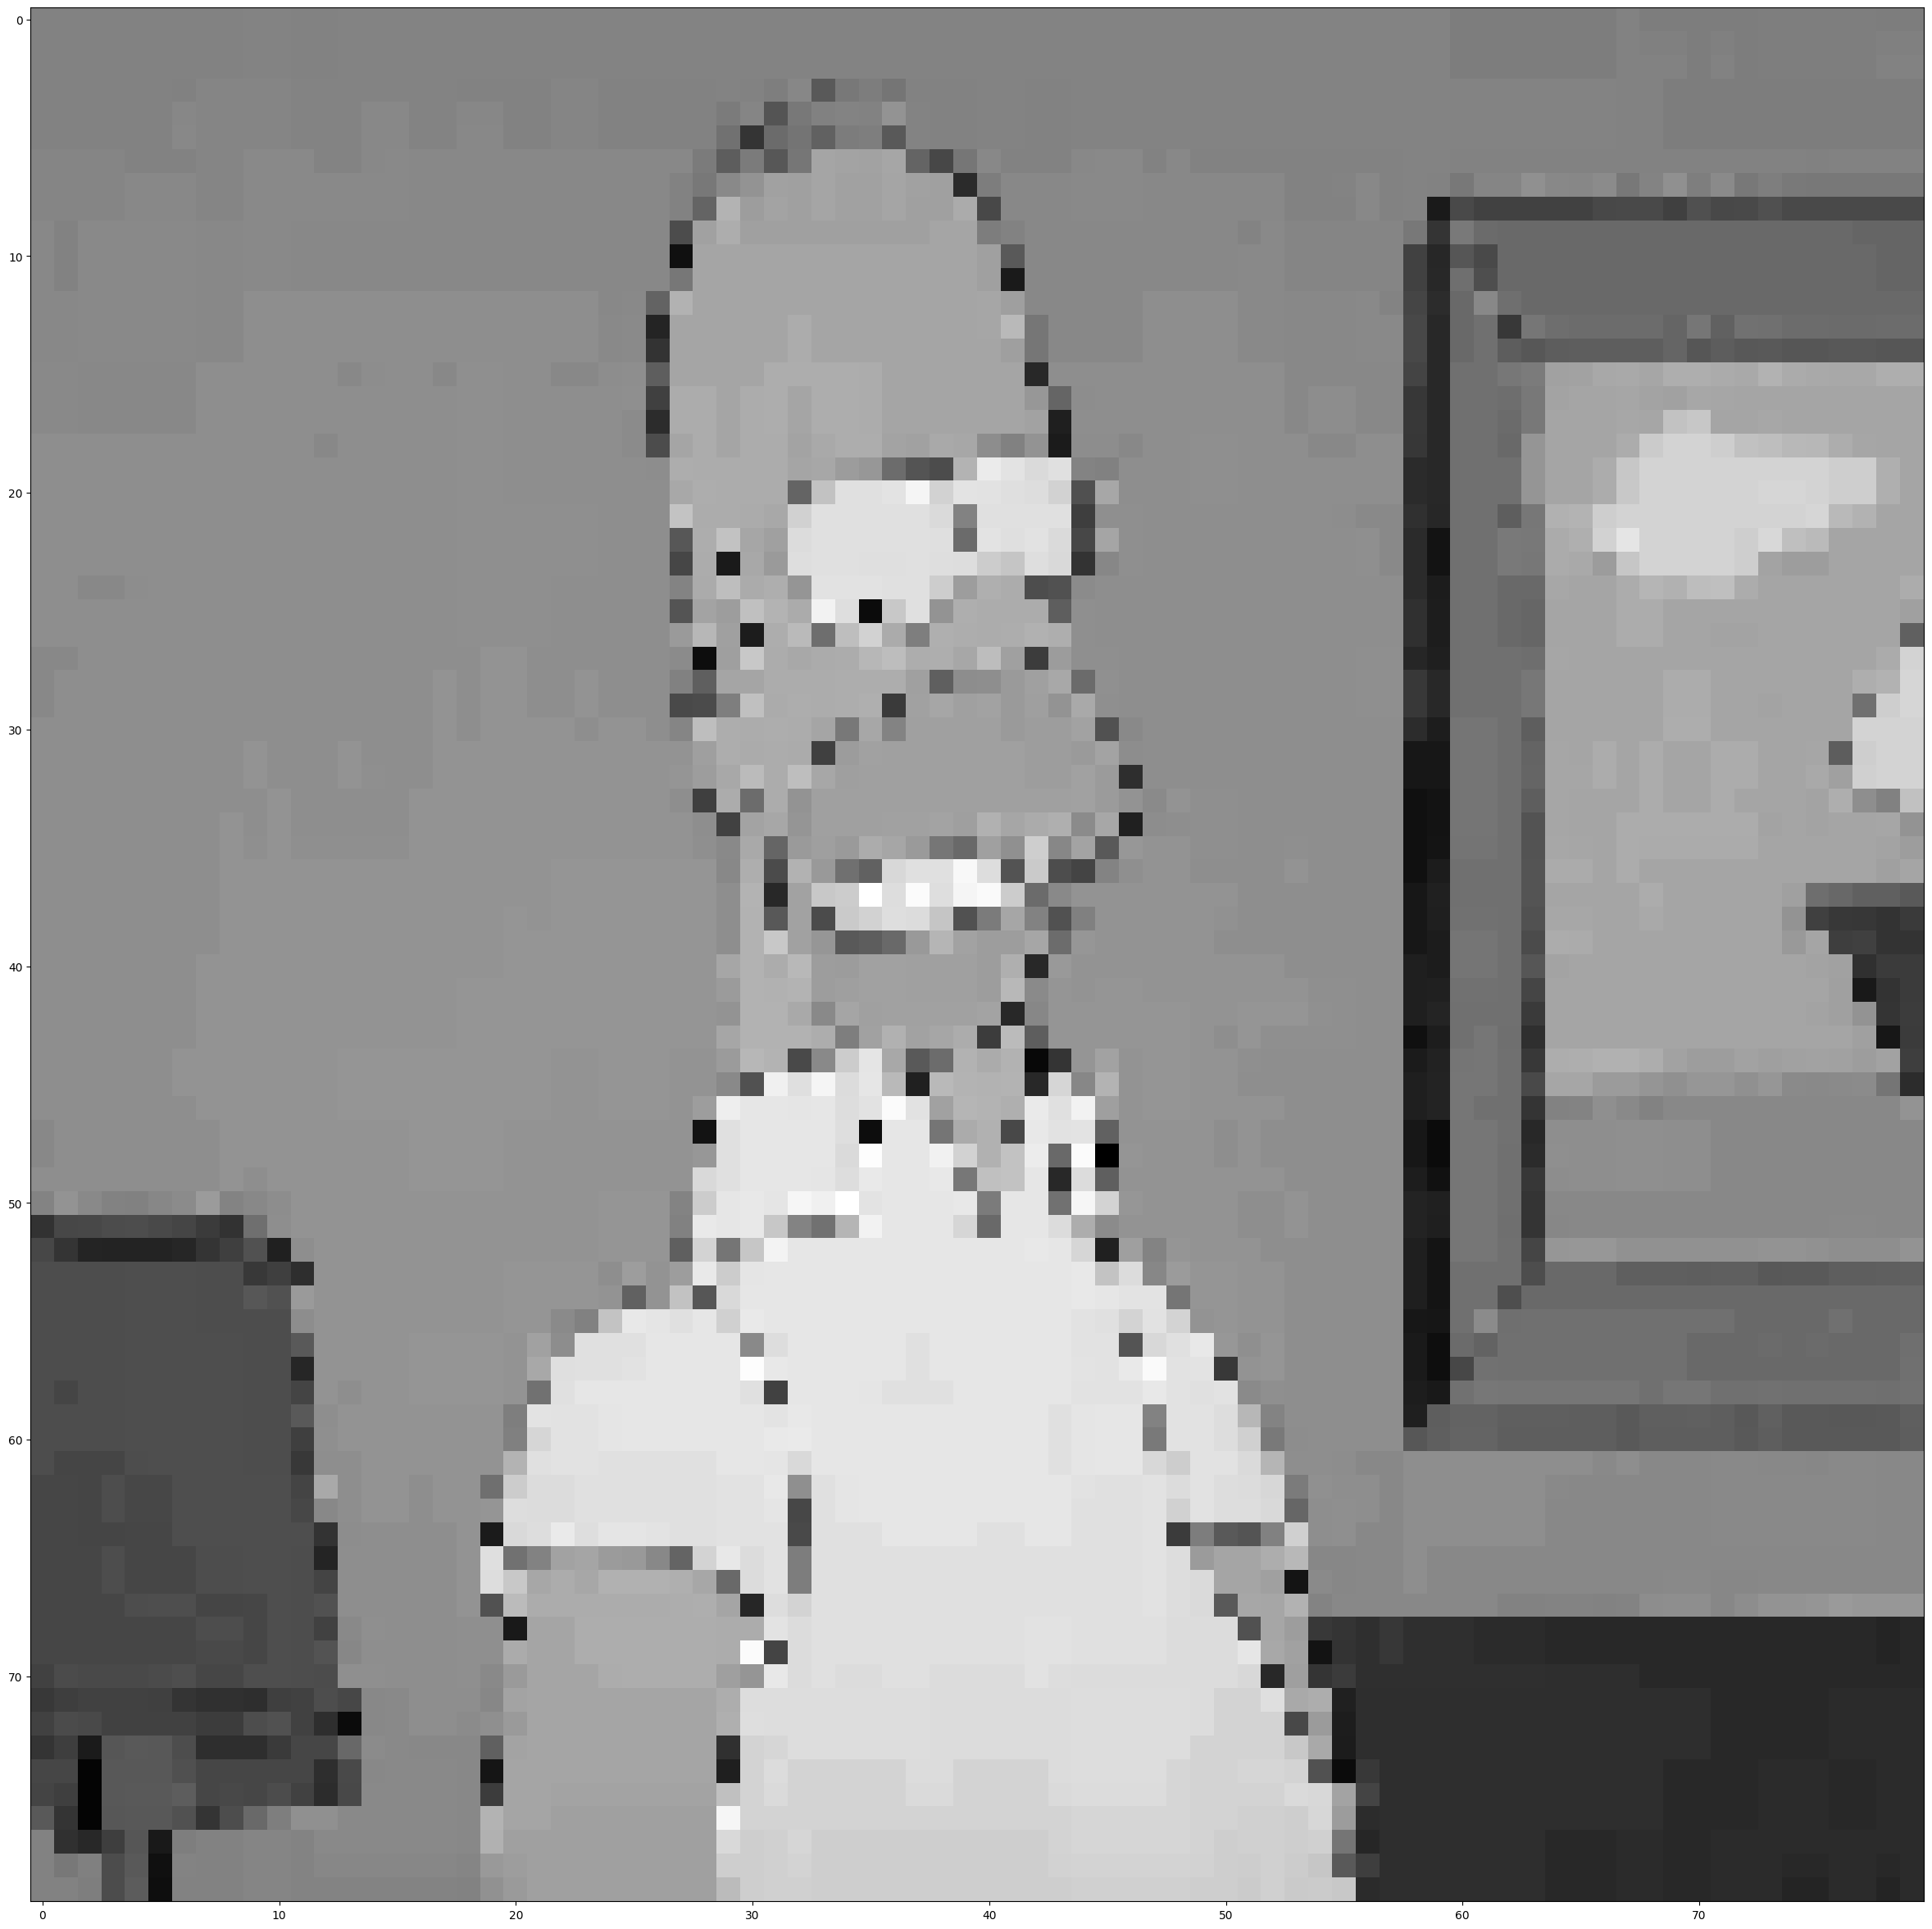

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
plt.imshow(train[0][0], cmap='gray')
plt.show()
# Không dùng opencv để mở ảnh vì nó không hoạt động tốt trong jupyter notebook

In [8]:
features, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

# Tiền xử lý

In [9]:
# Hàm sau tách training set thành features và labels và reshape lại feature set thành 4 dimensional tensor
# Normalize là 1 bước quan trọng giúp cải thiện hiệu suát model, việc này đảm bảo các feature trong training set có cùng range, mean
# Bằng cách này model được learn nhanh hơn, hiểu quả hơn và giảm thiểu các vấn đề do biên độ lớn hoặc sự không đồng đều giữa các feature gây ra
# Có nhiều phương pháp chuẩn hóa dữ liệu, một trong những phương pháp phổ biến là Z-score normalization, còn được gọi là Standardization
# Phương pháp này biến đổi các giá trị của mỗi đặc trưng thành một phân phối chuẩn với giá trị trung bình là 0 và độ lệch chuẩn là 1
# Cụ thể, các giá trị của mỗi đặc trưng sẽ được tính toán theo công thức sau:
# Normalize the features set ==> (0, 1)
features = caer.normalize(features)
# Sử dụng once hot encode để convert label về vector nhị phân
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels, len(characters))

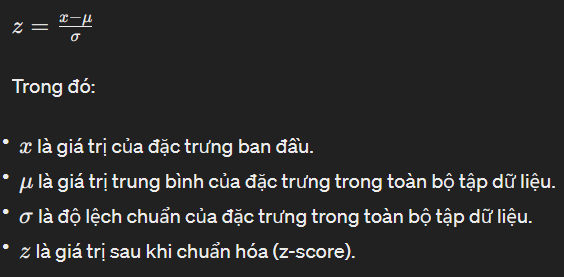

In [12]:
# val_ratio nghĩa là 20% là validation set
x_train, x_val, y_train, y_val = caer.train_val_split(features, labels, val_ratio=.2)

In [19]:
# Để quá trình train nhanh hơn, co stheer loại bỏ các biến không cần thiết
del train
del features
del labels
gc.collect()

50865

# Train

In [18]:
BATCH_SIZE = 32
EPOCHS = 10
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters), 
                                         loss='binary_crossentropy', decay=1e-7, learning_rate=0.001, momentum=0.9,
                                         nesterov=True)

ValueError: Argument(s) not recognized: {'lr': None}